In [50]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso, Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR

## Data preparation

In [51]:
df = pd.read_csv('train.csv')
df.head()

,Id,Cement,Blast Furnace Slag,Fly Ash,Water,Superplasticizer,Coarse Aggregate,Fine Aggregate,Age,Strength
0,230,376.0,0.0,0.0,214.6,0.0,1003.5,762.4,3,16.28
1,231,491.0,26.0,123.0,210.0,3.9,882.0,699.0,56,59.59
2,232,250.0,0.0,95.7,187.4,5.5,956.9,861.2,3,13.82
3,233,310.0,0.0,0.0,192.0,0.0,1012.0,830.0,90,35.76
4,234,252.1,97.1,75.6,193.8,8.3,835.5,821.4,28,33.40


In [52]:
df_test = pd.read_csv('test.csv')
df_test.head()

,Id,Cement,Blast Furnace Slag,Fly Ash,Water,Superplasticizer,Coarse Aggregate,Fine Aggregate,Age
0,0,167.4,129.9,128.6,175.5,7.8,1006.3,746.6,28
1,1,475.0,118.8,0.0,181.1,8.9,852.1,781.5,7
2,2,251.4,0.0,118.3,188.5,6.4,1028.4,757.7,100
3,3,307.0,0.0,0.0,193.0,0.0,968.0,812.0,365
4,4,143.6,0.0,174.9,158.4,17.9,942.7,844.5,28


In [53]:
df = df.drop(columns=['Id'])
x_test = df_test.drop(columns=['Id'])

In [54]:
df.shape

(800, 9)

In [55]:
# Проверяем пропущенные значения

((df.isna().sum() / len(df))*100).sort_values(ascending=False)

Cement                0.0
Blast Furnace Slag    0.0
Fly Ash               0.0
Water                 0.0
Superplasticizer      0.0
Coarse Aggregate      0.0
Fine Aggregate        0.0
Age                   0.0
Strength              0.0
dtype: float64

In [56]:
df.duplicated().sum()

19

In [57]:
df = df.drop_duplicates()
df.duplicated().sum()

0

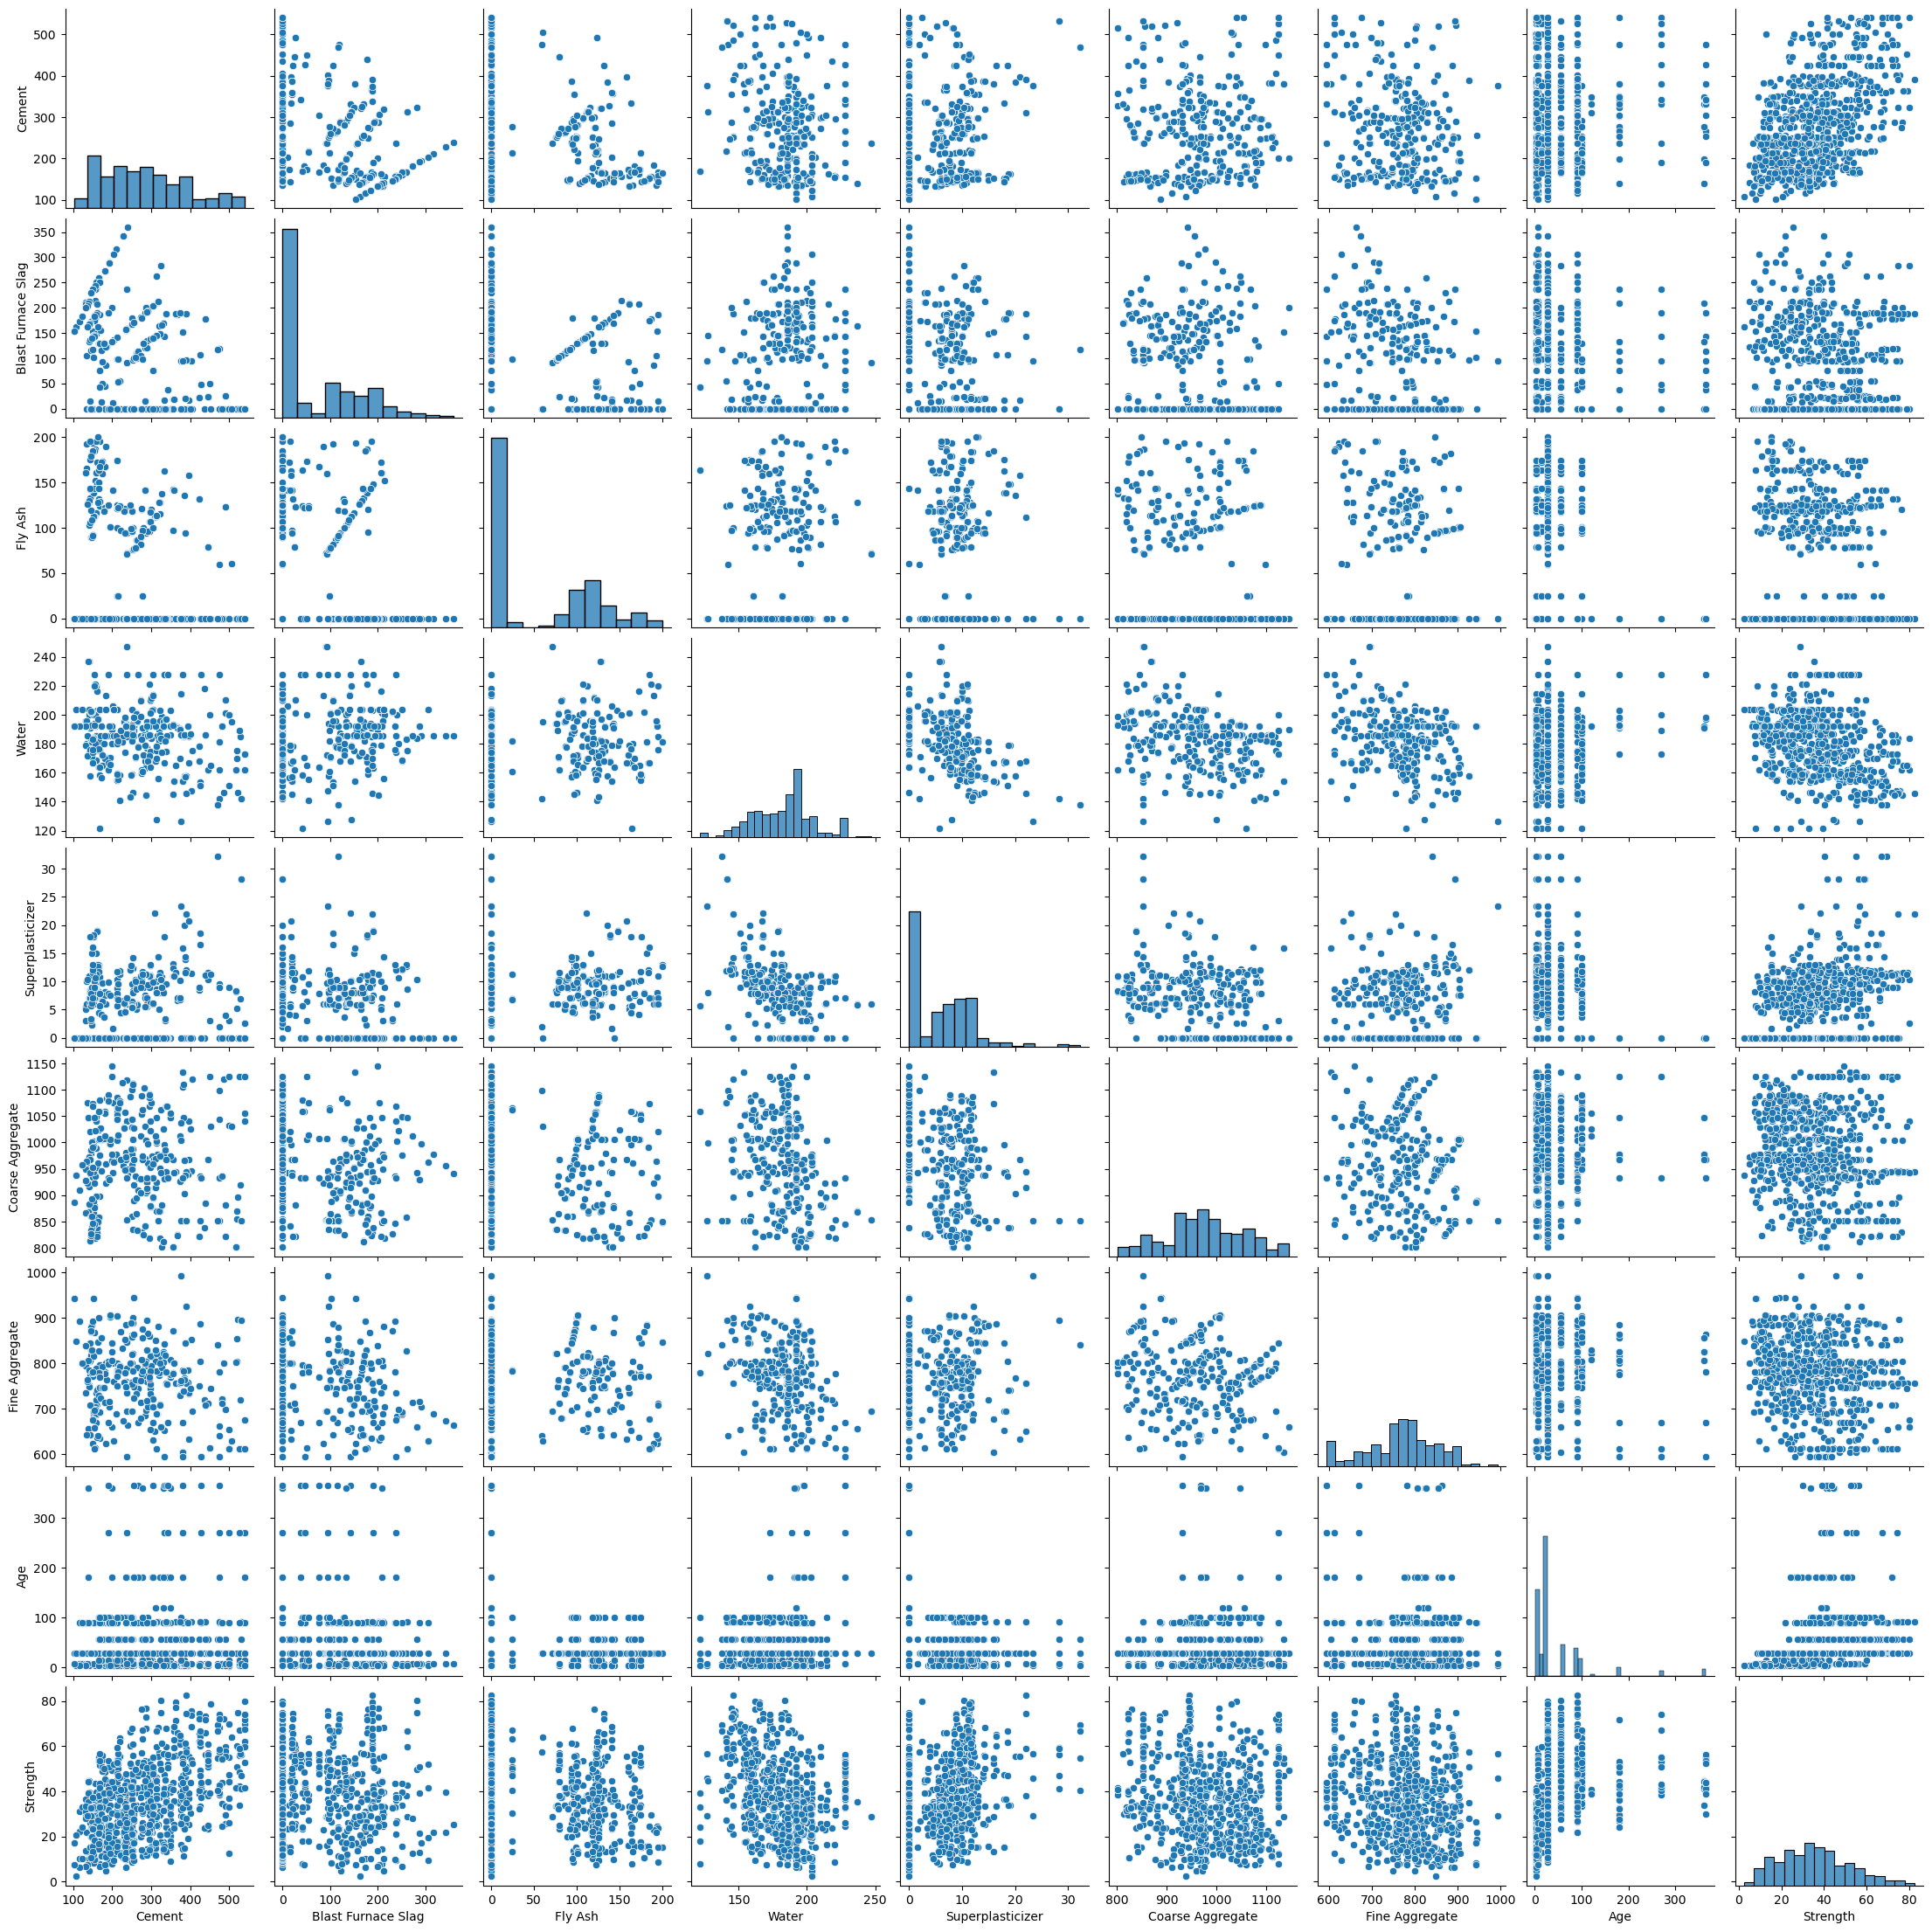

In [58]:
sns.pairplot(df)

In [59]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 781 entries, 0 to 798
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Cement              781 non-null    float64
 1   Blast Furnace Slag  781 non-null    float64
 2   Fly Ash             781 non-null    float64
 3   Water               781 non-null    float64
 4   Superplasticizer    781 non-null    float64
 5   Coarse Aggregate    781 non-null    float64
 6   Fine Aggregate      781 non-null    float64
 7   Age                 781 non-null    int64  
 8   Strength            781 non-null    float64
dtypes: float64(8), int64(1)
memory usage: 61.0 KB


In [60]:
df.describe()

,Cement,Blast Furnace Slag,Fly Ash,Water,Superplasticizer,Coarse Aggregate,Fine Aggregate,Age,Strength
count,781.000000,781.000000,781.000000,781.000000,781.000000,781.000000,781.000000,781.000000,781.000000
mean,282.957234,70.634827,53.953905,182.414725,5.949680,975.372727,770.940333,46.870679,35.708950
std,105.892462,86.561707,63.858469,21.723228,5.943043,78.371140,80.789893,64.511457,16.487136
min,102.000000,0.000000,0.000000,121.800000,0.000000,801.000000,594.000000,1.000000,2.330000
25%,194.700000,0.000000,0.000000,166.600000,0.000000,932.000000,721.000000,14.000000,23.740000
50%,272.800000,19.000000,0.000000,185.700000,6.000000,968.000000,779.700000,28.000000,33.950000
75%,350.000000,139.900000,118.300000,193.000000,10.000000,1040.000000,821.400000,56.000000,46.230000
max,540.000000,359.400000,200.100000,247.000000,32.200000,1145.000000,992.600000,365.000000,82.600000


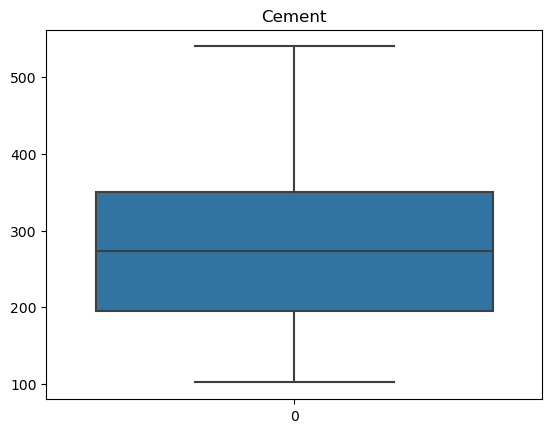

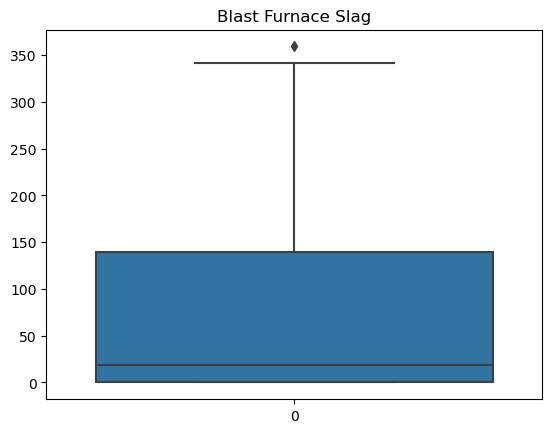

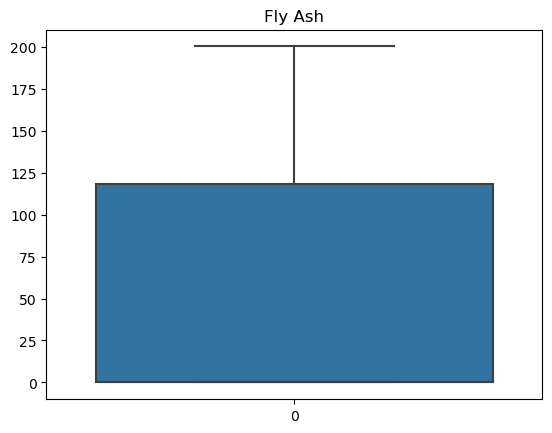

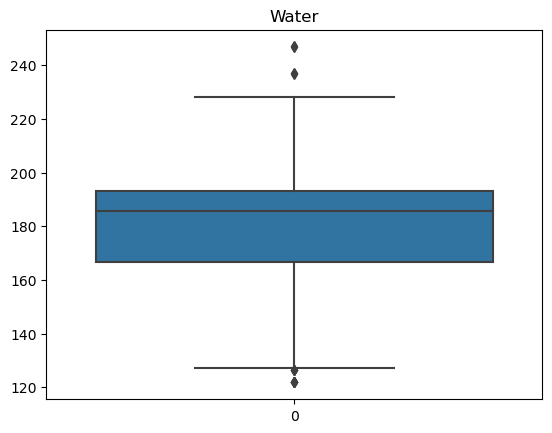

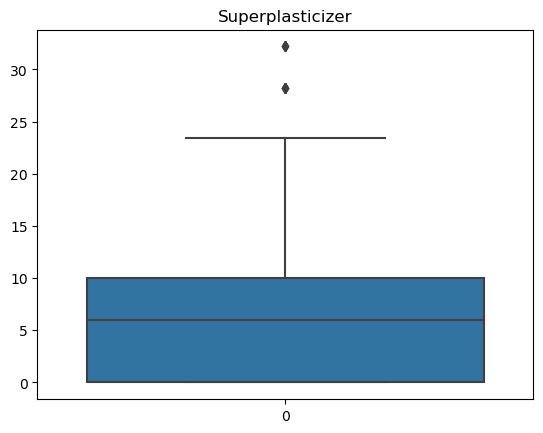

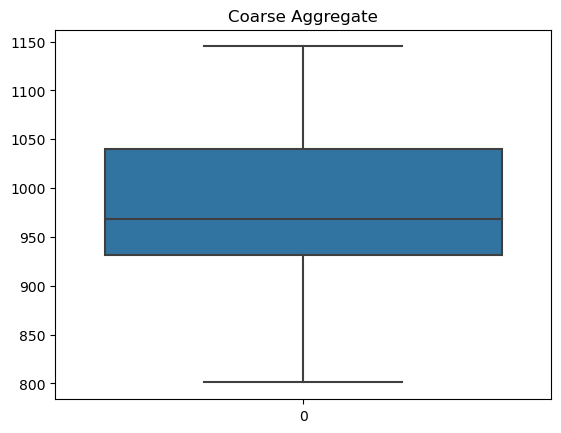

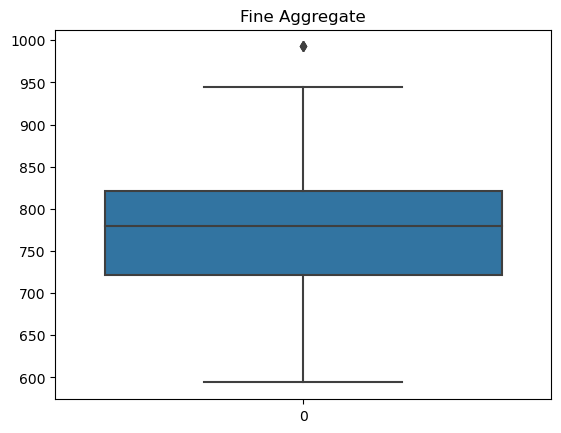

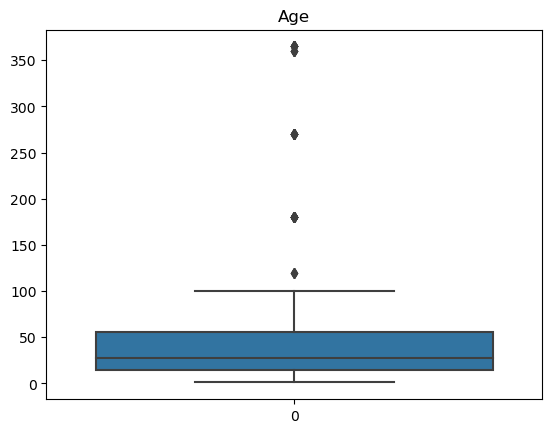

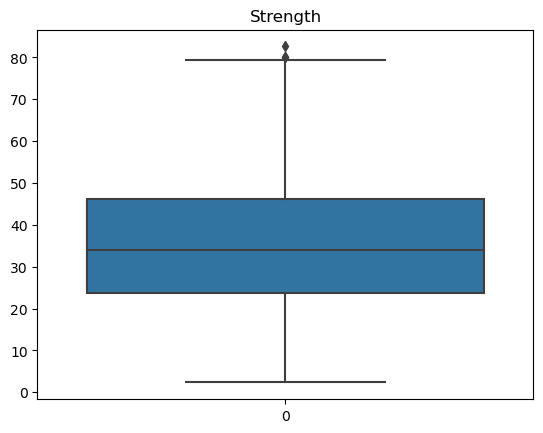

In [61]:
# Проверяем выбросы в признаках

for column in df.columns:
    plt.figure()
    sns.boxplot(df[column])
    plt.title(column)

In [62]:
x = df.drop(['Strength'], axis=1)
y = df['Strength']

In [63]:
def get_outliers(data):
    q25 = data.quantile(0.25)
    q75 = data.quantile(0.75)
    iqr = q75 - q25
    boundaries = (q25 - 1.5*iqr, q75  + 1.5*iqr)
    
    return boundaries

In [64]:
# Заменяем выбросы на граничное значение

for column in x.columns:
    x.loc[x[column] > get_outliers(x[column])[1], column] = get_outliers(x[column])[1]
    x.loc[x[column] < get_outliers(x[column])[0], column] = get_outliers(x[column])[0]
    x_test.loc[x_test[column] > get_outliers(x[column])[1], column] = get_outliers(x[column])[1]
    x_test.loc[x_test[column] < get_outliers(x[column])[0], column] = get_outliers(x[column])[0]

In [65]:
x.describe()

,Cement,Blast Furnace Slag,Fly Ash,Water,Superplasticizer,Coarse Aggregate,Fine Aggregate,Age
count,781.000000,781.000000,781.000000,781.000000,781.000000,781.000000,781.000000,781.000000
mean,282.957234,70.622471,53.953905,182.401921,5.892318,975.372727,770.861204,38.248399
std,105.892462,86.521115,63.858469,21.505776,5.726834,78.371140,80.582307,34.697480
min,102.000000,0.000000,0.000000,127.000000,0.000000,801.000000,594.000000,1.000000
25%,194.700000,0.000000,0.000000,166.600000,0.000000,932.000000,721.000000,14.000000
50%,272.800000,19.000000,0.000000,185.700000,6.000000,968.000000,779.700000,28.000000
75%,350.000000,139.900000,118.300000,193.000000,10.000000,1040.000000,821.400000,56.000000
max,540.000000,349.750000,200.100000,232.600000,25.000000,1145.000000,972.000000,119.000000


In [66]:
# Стандартизируем данные

scaler = StandardScaler()
columns = x.columns
x[columns] = scaler.fit_transform(x[columns])
x_test[columns] = scaler.transform(x_test[columns])

In [67]:
x.head()

,Cement,Blast Furnace Slag,Fly Ash,Water,Superplasticizer,Coarse Aggregate,Fine Aggregate,Age
0,0.879216,-0.816769,-0.845440,1.498142,-1.029555,0.359128,-0.105068,-1.016529
1,1.965920,-0.516071,1.081929,1.284109,-0.348115,-1.192181,-0.892345,0.511939
2,-0.311432,-0.816769,0.654147,0.232555,-0.068549,-0.235859,1.121793,-1.016529
3,0.255543,-0.816769,-0.845440,0.446588,-1.029555,0.467656,0.734363,1.492465
4,-0.291588,0.306220,0.339187,0.530340,0.420691,-1.785892,0.627572,-0.295554


In [68]:
x_test.head()

,Cement,Blast Furnace Slag,Fly Ash,Water,Superplasticizer,Coarse Aggregate,Fine Aggregate,Age
0,-1.091969,0.685561,1.169679,-0.321139,0.333326,0.394879,-0.301267,-0.295554
1,1.814726,0.557187,-0.845440,-0.060577,0.525528,-1.573943,0.132109,-0.901173
2,-0.298203,-0.816769,1.008282,0.283737,0.088707,0.677051,-0.163431,1.780855
3,0.227194,-0.816769,-0.845440,0.493117,-1.029555,-0.094135,0.510846,2.328796
4,-1.316869,-0.816769,1.895185,-1.116784,2.098084,-0.417165,0.914419,-0.295554


## Modeling

In [ ]:
# Тестируем различные модели с подбором гиперпараметров

params = {'alpha': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100, 1000],
         'fit_intercept':[True, False],
         'tol': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10]}

gs = GridSearchCV(Lasso(), params, cv=3, scoring='neg_root_mean_squared_error', n_jobs=-1)
gs.fit(x, y)

print('Лучшие параметры для Lasso: ', gs.best_params_)
print('Лучший результат для Lasso: ', gs.best_score_)

In [ ]:
params = {'solver':['svd', 'cholesky', 'lsqr', 'sag', 'auto'],
         'alpha': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100, 1000],
         'fit_intercept':[True, False]}

gs = GridSearchCV(Ridge(), params, cv=3, scoring='neg_root_mean_squared_error', n_jobs=-1)
gs.fit(x, y)

print('Лучшие параметры для Ridge: ', gs.best_params_)
print('Лучший результат для Ridge: ', gs.best_score_)

In [ ]:
params = {'n_estimators' : [100, 300, 500],
          'max_depth': np.arange(2, 25, 2),
          'max_features': ['sqrt', 'log2', None],
          'min_samples_leaf': np.arange(1, 10, 1),
          'min_samples_split': np.arange(2, 20, 1)}

gs = GridSearchCV(RandomForestRegressor(), params, cv=3, scoring='neg_root_mean_squared_error', n_jobs=-1)
gs.fit(x, y)

print('Лучшие параметры для RandomForestRegressor: ', gs.best_params_)
print('Лучший результат для RandomForestRegressor: ', gs.best_score_)

In [ ]:
params = {'n_neighbors': [2,3,4,5,6,7,8,9,10,11,12,13,14,15], 
          'weights': ['uniform','distance'],
          'p':[1,2,5]}

gs = GridSearchCV(KNeighborsRegressor(), params, cv=3, scoring='neg_root_mean_squared_error', n_jobs=-1)
gs.fit(x, y)

print('Лучшие параметры для KNeighborsRegressor: ', gs.best_params_)
print('Лучший результат для KNeighborsRegressor: ', gs.best_score_)

In [ ]:
params =  {'kernel' : ('linear', 'poly', 'rbf', 'sigmoid'),
           'C' : [1,5,10],
           'degree' : [3,8],
           'coef0' : [0.01,10,0.5],
           'gamma' : ('auto','scale')}

gs = GridSearchCV(SVR(), params, cv=3, scoring='neg_root_mean_squared_error', n_jobs=-1)
gs.fit(x, y)

print('Лучшие параметры для SVR: ', gs.best_params_)
print('Лучший результат для SVR: ', gs.best_score_)

In [73]:
params = {
    'hidden_layer_sizes': [(200,150,100),(500,500,500)],
    'max_iter': [2000,2500,3000],
    'activation': ['relu','logistic'],
    'solver': ['sgd','adam'],
    'alpha': [1,10],
    'learning_rate': ['adaptive','constant'],
}

gs = GridSearchCV(MLPRegressor(), params, cv=3, scoring='neg_root_mean_squared_error', n_jobs=-1)
gs.fit(x, y)

print('Лучшие параметры для MLPRegressor: ', gs.best_params_)
print('Лучший результат для MLPRegressor: ', gs.best_score_)

Лучшие параметры для MLPRegressor:  {'activation': 'relu', 'alpha': 10, 'hidden_layer_sizes': (600, 550, 500), 'learning_rate': 'adaptive', 'max_iter': 2000, 'solver': 'sgd'}
Лучший результат для MLPRegressor:  -4.933254896817631


C:\Users\mayor\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


In [74]:
# Обучаем лучшую модель

model = MLPRegressor(activation='relu', hidden_layer_sizes=(600, 550, 500), alpha=10,
                     learning_rate='adaptive', max_iter=2000, solver='sgd')
model.fit(x, y)

C:\Users\mayor\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (2000) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPRegressor(alpha=10, hidden_layer_sizes=(600, 550, 500),
             learning_rate='adaptive', max_iter=2000, solver='sgd')

In [75]:
test_pred = model.predict(x_test)

In [76]:
# Создаем файл, который будет использоваться для проверки качества модели на тестовой выборке

df_submission = pd.DataFrame(data= {
    'Id': df_test['Id'],
    'Strength': test_pred
})
df_submission.head()

,Id,Strength
0,0,41.480922
1,1,51.880852
2,2,42.546299
3,3,35.128240
4,4,15.787434


In [77]:
df_submission.to_csv('first_submission.csv', index=False)